In [369]:
import numpy as np

import sys

sys.path.append('../scripts')

In [370]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [371]:
from elements import *

import measurement as me

In [372]:
import matplotlib.pyplot as plt

# Basic optomechanics and Cooling

In the example below we simulate an optomechanical system. Here we can see the mechanical sidebands and cooling as a result of spectrum widening.

## Define optomechanical system

In [373]:
omega_c = 5e9*np.pi*2     # cavity resonance frequency

kappa_0 = 0.3e6*np.pi*2
kappa_ex = 0.4e6*np.pi*2

kappa = kappa_0 + kappa_ex

omega_m = 5e6*np.pi*2    # mechanical resonance frequency
gamma_m = 100*np.pi*2

P_in = 5e-12

g_0 = 200*np.pi*2

omega_drive = omega_c - 1* omega_m


from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']                # optomechanical coupling rate = sqrt(nbar) * g_0
omega_c = omdir['omega_c']   # new cavity resonance frequency



a = Mode('a', omega_c)
b = Mode('b', omega_m)

a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_drive, bath_temp=10e-3)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=10e-3)

b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)

g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [a_in0,b_in0 , a_inex], [g_ab])

C = 4 * g**2/kappa/gamma_m

print ('Cooperativity C: ',C)

Cooperativity C:  8.750407719405365


## Measurement 1: Mechanical Sidebands

<IPython.core.display.Javascript object>


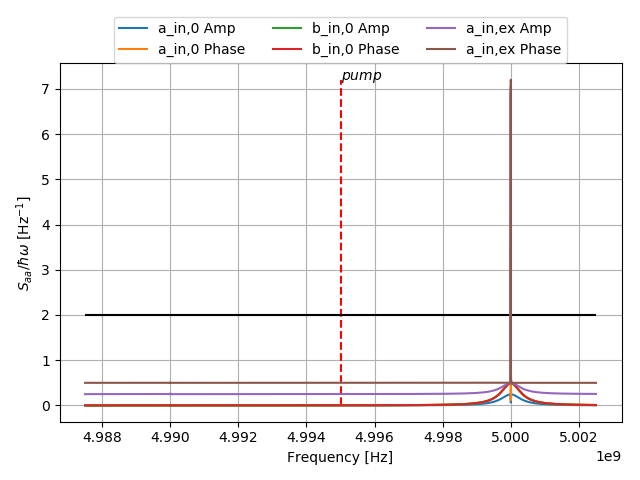

In [382]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_drive - 1.5*omega_m, omega_drive + 1.5*omega_m, 20001)
spec = me.spectrum(omegas,me.PowerMeasurement(a_outex), components = 1, plot = 1)

plt.vlines(omega_drive/2/np.pi,0,np.max(spec),linestyles='--',colors='red')
plt.annotate(r'$pump$', (omega_drive/2/np.pi , np.max(spec)));

## Measurement 2: Red sideband

<IPython.core.display.Javascript object>


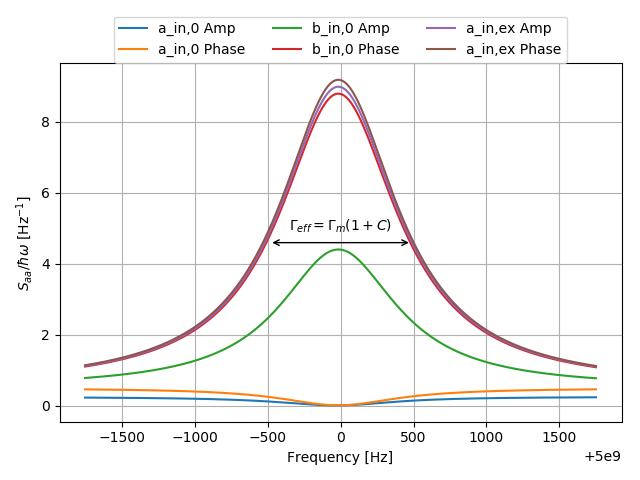

Text(5e+09,5.05106,'$\\Gamma_{eff} = \\Gamma_m(1+C)$')

In [418]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_drive + 1.*omega_m - C*2*gamma_m, omega_drive + 1.*omega_m + C*2*gamma_m, 10001)
spec = me.spectrum(omegas,me.PowerMeasurement(a_outex), components=True, plot = True)

gamma_eff = gamma_m * (1 + C)
f1 = 5e9 - (gamma_eff)/4/np.pi
f2 = 5e9 + (gamma_eff)/4/np.pi

h = max(spec[:,-1])/2
plt.annotate (r'', (f1 , h), (f2, h), arrowprops={'arrowstyle':'<->'})
plt.text(f1/2+f2/2, h*1.1, r'$\Gamma_{eff} = \Gamma_m(1+C)$', {'ha': 'center', 'va': 'center'})

### Linear Response

<IPython.core.display.Javascript object>


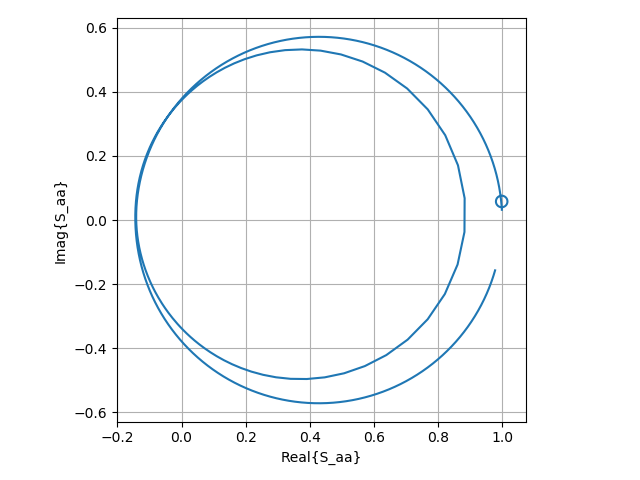

<IPython.core.display.Javascript object>


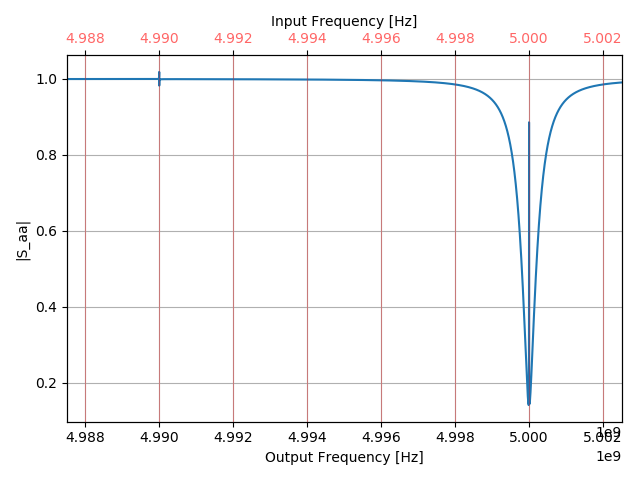

<IPython.core.display.Javascript object>


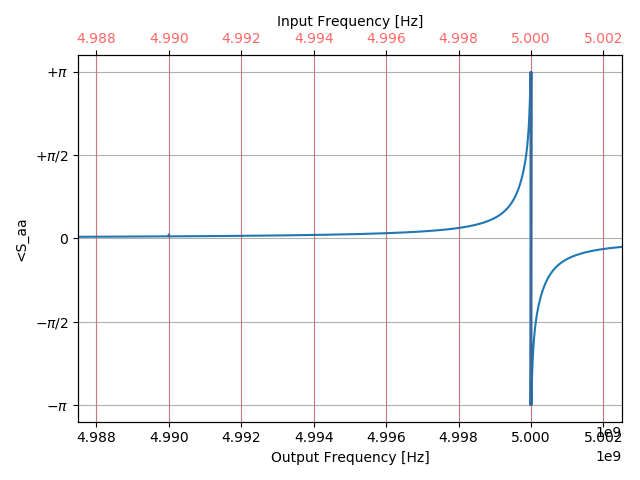

In [379]:
omegas = np.linspace(omega_drive - 1.5*omega_m, omega_drive + 1.5*omega_m, 300001)
omegas_new, A = me.linear_response(Input = a_inex, output = a_outex, Omegas=omegas, system=sys_om, plot =1)